In [1]:
# Importing necessary libraries to extract the data properly from Postgres using PySpark
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from API_Key import username, password
import requests
import time
import psycopg2 as pg2
import json
from pandas.io.json import json_normalize
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as psf
import pyspark.sql.types as pst
from scipy.stats import pointbiserialr

In [2]:
spark = SparkSession \
    .builder \
    .appName("TFT Analysis") \
    .config("spark.jars", "/Users/hiowatah/downloads/postgresql-42.2.18.jar") \
    .master("local[10]") \
    .getOrCreate()

In [3]:
df = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5432/TFT") \
    .option("dbtable", "matches") \
    .option("user", username) \
    .option("password", password) \
    .option("driver", "org.postgresql.Driver") \
    .load()

In [4]:
df.printSchema()

root
 |-- match: string (nullable = true)
 |-- game_datetime: long (nullable = true)
 |-- game_length: double (nullable = true)
 |-- game_version: string (nullable = true)
 |-- gold_left: integer (nullable = true)
 |-- last_round: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- placement: integer (nullable = true)
 |-- puuid: string (nullable = true)
 |-- time_eliminated: double (nullable = true)
 |-- total_damage: integer (nullable = true)
 |-- traits: string (nullable = true)
 |-- units: string (nullable = true)



In [9]:
df.units.

TypeError: 'Column' object is not callable

## Need to make a UDF to parse through the json strings and create arrays to make data processing easier

In [6]:
def jsonColParser(df, *cols, sanitize=True):
    res = df
    for i in cols:
        if sanitize:
            res = (
                res.withColumn(
                    i,
                    psf.concat(psf.lit('{"data": '), i, psf.lit('}'))
                )
            )
        schema = spark.read.json(res.rdd.map(lambda x: x[i])).schema
        res = res.withColumn(i, psf.from_json(psf.col(i), schema))
        
        if sanitize:
            res = res.withColumn(i, psf.col(i).data)
            
    return res

In [7]:
df = jsonColParser(df, "units", "traits")

In [8]:
df = df.where("game_version LIKE '%Version 11.2%'")

In [9]:
df.count()

52416

In [10]:
df.select(df.units.character_id).show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------+
|units.character_id                                                                                      |
+--------------------------------------------------------------------------------------------------------+
|[TFT4_Wukong, TFT4_Nasus, TFT4_Jax, TFT4_Irelia, TFT4_Sejuani, TFT4_Kayle, TFT4_Xayah]                  |
|[TFT4_Maokai, TFT4_Rakan, TFT4_Lulu, TFT4_Nunu, TFT4_Yuumi, TFT4_Shyvana, TFT4_Veigar, TFT4_Sett]       |
|[TFT4_Braum, TFT4_Teemo, TFT4_Yuumi, TFT4_Sivir, TFT4_Aatrox, TFT4_Sejuani, TFT4_Samira]                |
|[TFT4_Braum, TFT4_Nautilus, TFT4_Yuumi, TFT4_Katarina, TFT4_Neeko, TFT4_Darius, TFT4_Sejuani, TFT4_Olaf]|
|[TFT4b_Diana, TFT4b_Zed, TFT4_Pyke, TFT4_Akali, TFT4_Kennen, TFT4_Katarina, TFT4_Shen, TFT4_Talon]      |
+--------------------------------------------------------------------------------------------------------+
only showing top 5 rows



In [11]:
df = df.withColumn("unit_names", df.units.character_id)\
        .withColumn("units_tier", df.units.tier)\
        .withColumn("chosen", df.units.chosen)\
        .withColumn("items", df.units.items)\
        .withColumn("trait_name", df.traits['name'])\
        .withColumn("num_units_trait", df.traits.num_units)\
        .withColumn("trait_tier", df.traits.tier_current)\
        .withColumn("style", df.traits.style)\
        .withColumn("trait_tier_total", df.traits.tier_total)\
        .drop("units", "traits")

In [12]:
df.count()

52416

In [13]:
df.where("placement >= 4").groupBy("unit_names").count().orderBy("count", ascending=False).show(5, truncate = False)

+------------------------------------------------------------------------------------------------------------+-----+
|unit_names                                                                                                  |count|
+------------------------------------------------------------------------------------------------------------+-----+
|[TFT4b_Diana, TFT4_Teemo, TFT4_Pyke, TFT4_Akali, TFT4_Yuumi, TFT4b_Kindred, TFT4_Katarina, TFT4_Talon]      |115  |
|[TFT4_Elise, TFT4_TwistedFate, TFT4_Pyke, TFT4_Vladimir, TFT4_Kalista, TFT4_Sivir, TFT4_Aatrox, TFT4_Zilean]|84   |
|[TFT4_Maokai, TFT4_Rakan, TFT4_Lulu, TFT4_Nunu, TFT4_Veigar, TFT4_Xayah, TFT4_AurelionSol, TFT4_Ornn]       |67   |
|[TFT4_Maokai, TFT4_TahmKench, TFT4_Vi, TFT4_Nunu, TFT4_Shyvana, TFT4_ChoGath, TFT4_Sett, TFT4_Ornn]         |59   |
|[TFT4_Rakan, TFT4_Lulu, TFT4_Nunu, TFT4_Veigar, TFT4_Aatrox, TFT4_Xayah, TFT4_AurelionSol, TFT4_Ornn]       |59   |
+---------------------------------------------------------------

In [14]:
df.printSchema()

root
 |-- match: string (nullable = true)
 |-- game_datetime: long (nullable = true)
 |-- game_length: double (nullable = true)
 |-- game_version: string (nullable = true)
 |-- gold_left: integer (nullable = true)
 |-- last_round: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- placement: integer (nullable = true)
 |-- puuid: string (nullable = true)
 |-- time_eliminated: double (nullable = true)
 |-- total_damage: integer (nullable = true)
 |-- unit_names: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- units_tier: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- chosen: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- items: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: long (containsNull = true)
 |-- trait_name: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- num_units_trait: array (nullable = true)
 |  

In [15]:
df2 = df.toPandas()

In [16]:
df2.placement.corr(df2.total_damage)

-0.8998128651976676

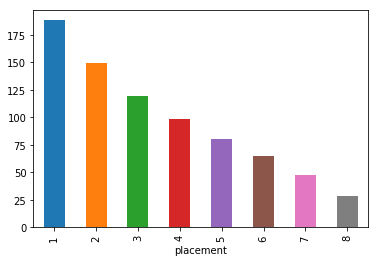

In [26]:
df2.groupby("placement").mean()['total_damage'].plot(kind='bar')
sns.

In [29]:
df2.unit_names.

0        [TFT4_Wukong, TFT4_Nasus, TFT4_Jax, TFT4_Ireli...
1        [TFT4_Maokai, TFT4_Rakan, TFT4_Lulu, TFT4_Nunu...
2        [TFT4_Braum, TFT4_Teemo, TFT4_Yuumi, TFT4_Sivi...
3        [TFT4_Braum, TFT4_Nautilus, TFT4_Yuumi, TFT4_K...
4        [TFT4b_Diana, TFT4b_Zed, TFT4_Pyke, TFT4_Akali...
5        [TFT4_Tristana, TFT4_Brand, TFT4_Braum, TFT4_S...
6        [TFT4_Yasuo, TFT4_Fiora, TFT4_Jax, TFT4_Irelia...
7        [TFT4_Elise, TFT4_TwistedFate, TFT4_Pyke, TFT4...
8        [TFT4b_Diana, TFT4_Nautilus, TFT4_Pyke, TFT4_A...
9        [TFT4_Wukong, TFT4_Janna, TFT4_Yuumi, TFT4_Nee...
10       [TFT4_Braum, TFT4_Nautilus, TFT4_Janna, TFT4_N...
11       [TFT4_Maokai, TFT4_TahmKench, TFT4_Rakan, TFT4...
12       [TFT4_Maokai, TFT4_TahmKench, TFT4_Annie, TFT4...
13       [TFT4_Brand, TFT4_Braum, TFT4_Annie, TFT4_Lulu...
14       [TFT4_Rakan, TFT4_Jax, TFT4_Irelia, TFT4b_Kind...
15       [TFT4_Rakan, TFT4_Lulu, TFT4_Nunu, TFT4_Veigar...
16       [TFT4b_Diana, TFT4_Janna, TFT4_Pyke, TFT4_Akal.